In [2]:
from docscorer.configuration import ScorerConfiguration
from docscorer.docscorer import DocumentScorer
import json
import pandas as pd
config = ScorerConfiguration()
scorer = DocumentScorer(config)
import os

In [21]:
path = "/mnt/d/Prompsit/Datos/HPLTv3_11_2025/hplt-v3-annotated-samples/cmn_Hans/cmn_Hans.sample.jsonl"
documents = []
with open(path, "r", encoding="utf8") as a:
    for document in a:
        documents.append(json.loads(document))

In [14]:


agrupations = {"ary_arab": "ara_arab", "ars_arab":"ara_arab", "acm_arab": "ara_arab", "acm_arab": "ara_arab", "acq_arab":"ara_arab", "aeb_arab":"ara_arab", "apc_arab":"ara_arab", "arb_arab":"ara_arab",
               "ars_arab":"ara_arab", "ary_arab":"ara_arab", "arz_arab":"ara_arab", "arb_arab": "ara_arab",
              "pes_arab": "fas_arab", "prs_arab" : "fas_arab",
              "hrv_latn": "hbs_latn", "bos_latn": "hbs_latn",
               "cmn_hant": "cmn_hans"
              }

path = "/mnt/d/Prompsit/Datos/HPLTv3_11_2025/hplt-v3-annotated-samples"
for x in os.listdir(path):
    rel_path = os.path.join(path, x)
    save_path = rel_path
    rel_path = os.path.join(rel_path, os.listdir(rel_path)[0])
    rel_path = "/mnt/d/Prompsit/Datos/HPLTv3_11_2025/hplt-v3-annotated-samples/pan_Guru/pan_Guru.sample.jsonl"
    save_path = "/mnt/d/Prompsit/Datos/HPLTv3_11_2025/hplt-v3-annotated-samples/pan_Guru/"
    documents = []
    with open(rel_path, "r", encoding="utf8") as a:
        for document in a:
            documents.append(json.loads(document))
    
    language = rel_path[-21:-18]
    script = rel_path[-17:-13]
    script = "hans" if script == "Hant" else script.lower()
    
    df = pd.DataFrame(columns=["id", "results", "text", "language", "old_score", "old_results"])
    for document in documents:
        if language in ["ara", "fas", "hbs", "cmn"]:
            document["seg_langs"] = [agrupations[x.lower()] if x.lower() in agrupations else x for x in document["seg_langs"]]
        
        result = scorer.score_document(ref_lang=language, ref_script=script, lang_segments=document["seg_langs"], document_text=document["text"], doc_id=document["id"], raw_score=False)
        df.loc[df.shape[0]] = [document["id"], result, document["text"], result[2], document["doc_scores"][0]/10, [x/10 for x in document["doc_scores"]]]

    df["WDS"] = df.apply(lambda x: f"{round(x['results'][0], 2)}/{round(x['old_results'][0], 2)}", axis=1)
    df["language"] = df.apply(lambda x: f"{float(round(x['results'][1], 2))}/{float(round(x['old_results'][1], 2))}", axis=1)
    df["urls"] = df.apply(lambda x: f"{float(round(x['results'][2], 2))}/{float(round(x['old_results'][2], 2))}", axis=1)
    df["punct"] = df.apply(lambda x: f"{float(round(x['results'][3], 2))}/{float(round(x['old_results'][3], 2))}", axis=1)
    df["sing_chars"] = df.apply(lambda x: f"{float(round(x['results'][4], 2))}/{float(round(x['old_results'][4], 2))}", axis=1)
    df["numbers"] = df.apply(lambda x: f"{float(round(x['results'][5], 2))}/{float(round(x['old_results'][5], 2))}", axis=1)
    df["repet_seg"] = df.apply(lambda x: f"{float(round(x['results'][6], 2))}/{float(round(x['old_results'][6], 2))}", axis=1)
    df["many_long"] = df.apply(lambda x: f"{float(round(x['results'][7], 2))}/{float(round(x['old_results'][7], 2))}", axis=1)
    df["very_long"] = df.apply(lambda x: f"{float(round(x['results'][8], 2))}/{float(round(x['old_results'][8], 2))}", axis=1)
    df["compression"] = df.apply(lambda x: f"{float(round(x['results'][9], 2))}/{float(round(x['old_results'][9], 2))}", axis=1)
    df["short_seg"] = df.apply(lambda x: f"{float(round(x['results'][10], 2))}/NaN", axis=1)
    df["text"] = df.text.apply(lambda x: x.replace("\n", "\\n"))
    df[['id', 'WDS', 'language', 'urls', 'punct', 'sing_chars', 'numbers', 'repet_seg', 'many_long',
        'very_long', 'compression', 'short_seg', 'text'
       ]].to_csv(os.path.join(save_path, f"{language}_{script}.tsv"), sep="\t",index=False)
        

    print(save_path)
    break

/mnt/d/Prompsit/Datos/HPLTv3_11_2025/hplt-v3-annotated-samples/pan_Guru/


In [7]:
config.SCRIPTS

array(['latn', 'arab', 'cyrl', 'beng', 'grek', 'gujr', 'hebr', 'deva',
       'armn', 'jpan', 'knda', 'geor', 'hang', 'mlym', 'mymr', 'guru',
       'sinh', 'taml', 'telu', 'thai', 'hans'], dtype=object)

In [24]:
(1*0.8)*0.32*0.92

0.23552

In [24]:
agrupations = {"ary_arab": "ara_arab", "ars_arab":"ara_arab", "acm_arab": "ara_arab", "acm_arab": "ara_arab", "acq_arab":"ara_arab", "aeb_arab":"ara_arab", "apc_arab":"ara_arab", "arb_arab":"ara_arab",
               "ars_arab":"ara_arab", "ary_arab":"ara_arab", "arz_arab":"ara_arab", "arb_arab": "ara_arab",
              "pes_arab": "fas_arab", "prs_arab" : "fas_arab",
              "hrv_latn": "hbs_latn", "bos_latn": "hbs_latn",
                "cmn_hans": "zho_hans",
               "cmn_hant": "zho_hant",
                "ekk_latn": "est_latn",
                "fil_latn": "tlg_latn",
                "gug_latn": "grn_latn",
                "ktu_latn": "kon_latn"
              }

document = documents[18]
language = "zho"
script = "hant"
document["seg_langs"] = [agrupations[x.lower()] if x.lower() in agrupations else x for x in document["seg_langs"]]
scorer.score_document(ref_lang=language, ref_script=script, lang_segments=document["seg_langs"], document_text=document["text"], doc_id=document["id"], raw_score=False)

[np.float64(0.40147290211305015),
 0.7,
 1.0,
 np.float64(0.7),
 1.0,
 1.0,
 1.0,
 0.1,
 0.0,
 1.0,
 0.95]

In [26]:
for i in range(len(feat["punctuation_chars"])):
    print(feat["punctuation_chars"][i])
    print(x["text"].split("\n")[i])
    

2
更新时间：2018-11-21
1
优势测量稳定可靠，受介质和过程条件变化的影响HistoROM集成据存储单元，帮助快速调试、维修和诊断
1
适用于固料物位测量的经济、高效的基本型仪表
8
Micropilot FMR56为固料贮仓或货柜等轻型工况条件下的物位测量而设计。Micropilot适合粉状、粒状等固体散料的连续、非接触式的物位测量。测量值受粉尘、进料噪音、温度变化、气相介质的影响。
0
优势
0
测量稳定可靠，受介质和过程条件变化的影响
1
HistoROM集成据存储单元，帮助快速调试、维修和诊断
0
测量可靠性高，基于多回波追踪计算，即使仓内存在障碍物依然能够准确测量
0
硬件和软件开发过程符合IEC 61508标准，单台仪表满足SIL2， 同构冗余条件下达SIL3
0
无缝集成到控制或设备管理系统
0
直观的菜单引导式操作（在线或通过控制系统）
0
通过世界的SIL和WHG实验认证，节约您的时间和经济成本
0
应用领域
1
PP镀层的喇叭天线，可通过安装支架或密封转盘，轻松对准固体表面。
0
过程连接：安装支架或松套法兰
4
温度范围：-40+80°C (-40+176°F)
6
压力范围：-13bar (-14.543.5psi)
1
大测量范围：30m（98ft)
1
K波段: 26GHz
2
际防爆认证, 5-point线性协议


In [24]:
feat

{'word_chars': [5,
  49,
  20,
  91,
  2,
  20,
  27,
  34,
  38,
  14,
  21,
  28,
  4,
  31,
  14,
  7,
  11,
  10,
  6,
  14],
 'punctuation_chars': [2,
  1,
  1,
  8,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  4,
  6,
  1,
  1,
  2],
 'singular_chars': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0],
 'numbers': [8, 0, 0, 2, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 9, 8, 4, 2, 1]}

In [15]:
i = 0
for x in documents:
    if x["id"] == "e2b083b29670330bce54e4cd15ce8330":
        print(x)
        print(x["text"])
        print(x["seg_langs"])
        print(i)
        break
    i+=1

{'f': './segments/1679296948673.1/warc/CC-MAIN-20230327154814-20230327184814-00693.warc.gz', 'o': 284316624, 's': 13175, 'rs': 52201, 'u': 'https://factsof99.com/2023/03/%E0%A8%95%E0%A9%81%E0%A9%9C%E0%A9%80%E0%A8%86%E0%A8%82-%E0%A8%A6%E0%A9%87-%E0%A8%B9%E0%A9%8B%E0%A8%B8%E0%A8%9F%E0%A8%B2-%E0%A8%A6%E0%A9%87-%E0%A8%B5%E0%A8%BF%E0%A8%9A-%E0%A8%B5%E0%A9%9C%E0%A8%BF/', 'c': 'text/html', 'ts': '2023-03-27T16:16:22Z', 'de': 'utf-8', 'crawl_id': 'CC-MAIN-2023-14', 'lang': ['pan_Guru', 'acm_Arab', 'arz_Arab'], 'prob': [1.0, 0.0, 0.0], 'text': 'ਅ ਸੀਂ ਹਰ ਰੋਜ਼ ਸੋਸ਼ਲ ਮੀਡੀਆ ਤੇ ਬਹੁਤ ਸਾਰੀਆਂ ਖ਼ਬਰਾਂ ਦੇਖਦੇ ਰਹਿੰਦੇ ਹਾਂ ਜਿਨ੍ਹਾਂ ਨੂੰ ਦੇਖ ਕੇ ਸਾਨੂੰ ਬਹੁਤ ਹੀ ਜ਼ਿਆਦਾ ਹੈਰਾਨੀ ਹੁੰਦੀ ਅਤੇ ਕੁਝ ਅਜਿਹੀਆਂ ਵੀ ਵੀਡੀਓ ਹੁੰਦੀਆਂ ਹਨ ਜਿਨ੍ਹਾਂ ਨੂੰ ਦੇਖ ਕੇ ਖੁਸ਼ੀ ਮਿਲਦੀ ਹੈ ਇੱਕ ਵੀਡੀਓ ਬਹੁਤ ਹੀ ਜਿਆਦਾ ਵਾਇਰਲ ਹੋ ਰਹੀ ਹੈ,\nਅੱਜ ਦੀ ਇਸ ਵੀਡੀਓ ਦੇ ਵਿਚ ਸੁਣਿਆ ਜਾ ਸਕਦਾ ਹੈ ਕੇ ਇਕ ਕੁੜੀ ਦੇ ਵਲੋਂ ਕਿਹਾ ਜਾਂਦਾ ਹੈ ਕੇ ਇਕ ਮੁੰਡਾ ਕੁੜੀਆਂ ਦੇ ਹੋਸਟਲ ਦੇ ਵਿਚ ਆਉਂਦਾ ਹੈ ਅਤੇ ਉਹ ਮੁੰਡਾ ਹੋਸਟਲ ਦਾ ਨਹੀਂ ਹੈ, ਉਹ ਬਾਹਰ ਦਾ ਹੈ। ਉਹਨਾਂ ਨੇ ਕਿਹਾ ਕੇ ਇਹ ਪਹਿਲਾ ਵੀ ਹੋ ਚੁਕਿਆ ਹੈ ਅਤੇ ਇਹ ਦੂਸਰੀ ਵਾਰ ਹੋਇਆ ਹੈ

In [16]:
feat = scorer._extract_features(document_text=x["text"])

In [7]:
scorer.score_document(ref_lang="ell", ref_script="grek", lang_segments=x["seg_langs"], document_text=x["text"], doc_id=x["id"], raw_score=False)

[0.0, 0.0, 1.0, 0.84, 1.0, 0.63, 1.0, 0.0, 0.0, 1.0, 1.0]

In [17]:
from typing import Any
def get_threshold(
    table: dict[str, Any], language: str, default_key: str = "standard"
) -> Any:
    """Fetch a language-specific threshold, falling back to `default_key`."""
    try:
        script = language.split("_")[1]
        if language in table:
            return table[language]
        elif script in table:
            return table[script]
        else:
            return table[default_key]
    except KeyError:
        raise KeyError(
            f"Neither '{language}' nor default '{default_key}' found in {table}."
        ) from None
ref_language = "hye_armn"
menu_length = get_threshold(config.MENUS_AVERAGE_LENGTH, ref_language)
correct_lang_chars = 0
wrong_lang_chars = 0
available_chars = False
lang_segments = [x.lower() for x in x["seg_langs"]]
word_chars = feat["word_chars"]
for n in range(len(lang_segments)):
    if word_chars[n] <= menu_length:
        available_chars = True
        continue
    elif lang_segments[n] == ref_language:
        correct_lang_chars += word_chars[n]
    else:
        wrong_lang_chars += word_chars[n]
if correct_lang_chars == 0:
    if not available_chars:
        # print(
        #     f"Doc_name: '{id}' - No available segments have been found on "
        #     "the target language\n"
        #     f"- Language: '{ref_language}' - Segment_languages: "
        #     f"{set(lang_segments)}"
        # )
        print("no chars")

    else:
        if all([x == ref_language for x in lang_segments]):
            print(1)
        # print(
        #     f"Doc_name: '{id}' - "
        #     "Only too short segments have been found on the target language"
        # )
        print("solo cortos")
results = correct_lang_chars / (correct_lang_chars + wrong_lang_chars)
print( min(results, 1.0))

no chars
0.0


In [13]:
menu_length

26

In [18]:
def scale_value(
    value: float,
    min_value: float,
    max_value: float,
    min_score: float,
    max_score: float,
) -> float:
    """Scale a value linearly into a score range."""
    if min_value == max_value:
        return 0.0

    ratio = (value - min_value) / (max_value - min_value)
    score = ratio * (max_score - min_score) + min_score
    return score
    
class PunctScorer:
    MAX_SCORE = 1.0
    MIN_SCORE = 0.0

    def __init__(self, config: ScorerConfiguration):
        self.config = config
    
    def penalize_lack_punct_segm(self, punct_chars: list, word_chars: list, num_word_chars: int, not_penalized: float, percent_bad: float) -> float:
        bad_segm = 0
        for n in range(len(punct_chars)):
            n_word_seg = word_chars[n]
            n_punct_seg = punct_chars[n]
            if not n_word_seg or n_word_seg <= not_penalized:
                continue
            ratio = round((n_punct_seg / n_word_seg) * 100, 1)
            if ratio < percent_bad:
                print(n)
                bad_segm += n_word_seg
        proportion_bad = bad_segm/num_word_chars
        print("bad_Seg",bad_segm)
        print("total",num_word_chars)
        print("proporcion",proportion_bad)
        if proportion_bad < 0.05:
            return 1
        elif proportion_bad > 0.4:
            return 0
        elif proportion_bad > 0.05 and proportion_bad < 0.2:
            return scale_value(proportion_bad, 0.2, 0.05, 0.6, 1.0)
        else:
            return scale_value(proportion_bad, 0.4, 0.2, 0, 0.6)
    
    def score(
        self, ref_language: str, num_punctuation_chars: int, num_word_chars: int, punct_chars: list, 
        word_chars: list) -> float:
        if not num_word_chars or len(punct_chars) != len(word_chars):
            return 0.0
    
        percent_max = get_threshold(self.config.PUNCTUATION_PERCENT_MAX, ref_language)
        percent_bad = get_threshold(self.config.PUNCTUATION_PERCENT_BAD, ref_language)
        percent_semibad = get_threshold(
            self.config.PUNCTUATION_PERCENT_SEMIBAD, ref_language
        )
        percent_desired_max = get_threshold(
            self.config.PUNCTUATION_PERCENT_DESIRED_MAX, ref_language
        )
        percent_desired_min = get_threshold(
            self.config.PUNCTUATION_PERCENT_DESIRED_MIN, ref_language
        )
    
        ratio = round((num_punctuation_chars / num_word_chars) * 100, 1)
        
        score = 0.0
        if percent_desired_min <= ratio <= percent_desired_max:
            score = self.MAX_SCORE
        elif ratio >= percent_bad[0]:
            ratio = min(ratio, percent_max)
            score = scale_value(ratio, percent_max, percent_bad[0], self.MIN_SCORE, 0.5)
        elif ratio >= percent_semibad[0]:
            score = scale_value(ratio, percent_bad[0], percent_semibad[0], 0.5, 0.7)
        elif ratio > percent_desired_max:
            score = scale_value(
                ratio, percent_semibad[0], percent_desired_max, 0.7, self.MAX_SCORE
            )
        elif ratio >= percent_semibad[1]:
            score = scale_value(
                ratio, percent_semibad[1], percent_desired_min, 0.5, self.MAX_SCORE
            )
        else:
            score = scale_value(ratio, 0.0, percent_semibad[1], self.MIN_SCORE, 0.5)
    
        if score < 0.3:
            return score
        menu_length = get_threshold(self.config.MENUS_AVERAGE_LENGTH, ref_language)
        penalize_lack_punct_segm = self.penalize_lack_punct_segm(punct_chars=punct_chars, word_chars=word_chars, num_word_chars=num_word_chars, not_penalized=menu_length*3, percent_bad=percent_bad[1])
        return min(score, penalize_lack_punct_segm)

In [19]:
puntuacion = PunctScorer(config)

In [20]:
puntuacion.score("hye_armn", sum(feat["punctuation_chars"]), sum(feat["word_chars"]), feat["punctuation_chars"], feat["word_chars"])

4
5
bad_Seg 680
total 1327
proporcion 0.5124340617935192


0

In [22]:
x["text"].split("\n")[5]

'ਅਸੀਂ ਤਾਜ਼ਾ ਜਾਣਕਾਰੀ ਤਾਜ਼ੀਆਂ ਖ਼ਬਰਾਂ ਪੰਜਾਬੀ ਵਾਇਰਲ ਖ਼ਬਰਾਂ ਅਤੇ ਇੰਟਰਟੇਨਮੈਂਟ ਖ਼ਬਰਾਂ ਤੁਹਾਡੇ ਲਈ ਲੈ ਕੇ ਆਉਂਦੇ ਹਾਂ ਜੇਕਰ ਤੁਸੀਂ ਚਾਹੁੰਦੇ ਹੋ ਕਿ ਅਸੀਂ ਤੁਹਾਡੇ ਲਈ ਇਸ ਤਰ੍ਹਾਂ ਦੇ ਹੋਰ ਆਰਟੀਕਲ ਲੈ ਕੇ ਆਈਏ ਤੁਹਾਡੇ ਪੇਜ ਲਾਈਕ ਜਰੂਰ ਕਰੋ ਅਤੇ ਸਾਡੇ ਆਰਟੀਕਲ ਨੂੰ ਵੱਧ ਤੋਂ ਵੱਧ ਸ਼ੇਅਰ ਕਰੋ ਤਾਂ ਕਿ ਅਸੀਂ ਹੋਰ ਜਾਣਕਾਰੀਆਂ ਤੁਹਾਡੇ ਲਈ ਲੈ ਕੇ ਆ ਸਕੀਏ ਜੇਕਰ ਤੁਸੀਂ ਸਾਡਾ ਆਰਟੀਕਲ ਅੱਗੇ ਸ਼ੇਅਰ ਕਰਦੇ ਹੋ ਤਾਂ ਇਸ ਨਾਲ ਸਾਡਾ ਵੀ ਮਾਣ ਹੋਰ ਵਧ ਜਾਂਦਾ ਹੈ ਤੁਸੀਂ ਆਪਣਾ ਇੱਕ ਸੁਝਾਅ ਜ਼ਰੂਰ ਪੇਸ਼ ਕਰੋ ਤਾਂ ਕਿ ਅਸੀਂ ਆਉਣ ਵਾਲੀਆਂ ਜਾਣਕਾਰੀਆਂ ਦੇ ਵਿੱਚ ਹੋਰ ਸੁਧਾਰ ਕਰ ਸਕੀਏ'

In [6]:
feat["punctuation_chars"][4]

2

In [53]:
print(x["text"])

041.0671.110618
ՀԱՅԱՍՏԱՆԻ ՀԱՆՐԱՊԵՏՈՒԹՅԱՆ ՎԱՐՉԱՊԵՏ
ՈՐՈՇՈՒՄ
11 հունիսի 2018 թվականի N 671-Ա
ԱՐԱՅԻԿ ՊԵՏՐՈՍՅԱՆԻՆ ՀԱՅԱՍՏԱՆԻ ՀԱՆՐԱՊԵՏՈՒԹՅԱՆ ԱՇԽԱՏԱՆՔԻ ԵՎ ՍՈՑԻԱԼԱԿԱՆ ՀԱՐՑԵՐԻ ՆԱԽԱՐԱՐԻ ԱՌԱՋԻՆ ՏԵՂԱԿԱԼԻ ՊԱՇՏՈՆԱԿԱՏԱՐԻ ՊԱՇՏՈՆԻՑ ԱԶԱՏԵԼՈՒ ՄԱՍԻՆ
i
Ղեկավարվելով «Հանրային ծառայության մասին» օրենքի 9-րդ հոդվածի 1-ին մասով`
Արայիկ Պետրոսյանին ազատել Հայաստանի Հանրապետության աշխատանքի և սոցիալական հարցերի նախարարի առաջին տեղակալի պաշտոնակատարի պաշտոնից` իր դիմումի համաձայն:
ՍՏՈՐԱԳՐՎԵԼ Է ՀԱՅԱՍՏԱՆԻ ՀԱՆՐԱՊԵՏՈՒԹՅԱՆ ՎԱՐՉԱՊԵՏԻ ԿՈՂՄԻՑ
2018 ԹՎԱԿԱՆԻ ՀՈՒՆԻՍԻ 11-ԻՆ


In [70]:
feat["word_chars"][4]/sum(feat["word_chars"])

0.2850574712643678

In [62]:
scale_value(0.05, 0.2, 0.05, 0.6, 1.0)

1.0

In [15]:
import math
alpha = 1
def exponent(subscore, subscores, alpha, beta=3):
            a = subscore**-alpha    
            b = sum([x**-alpha for x in subscores])
            return a/b*beta
        
penalty_scores = [
0.41,
0.95,
0.98,
0.95,
1,
1,
1,

    ]

P = math.prod([x**exponent(x, penalty_scores, alpha) for x in penalty_scores])

base_score = (
    0.97 * 0.8
    + 1/10
    + 0.62/10
) * P
base_score


0.41862920588006364

In [13]:
segments = x["text"].split("\n")
segments = [seg for seg in segments if len(seg) > 4]

num_duplicates = len(segments) - len(set(segments))
repetition_ratio = num_duplicates / len(segments)
score = (1 - repetition_ratio)
score

0.49411764705882355

In [14]:
len(set(segments))

42

In [15]:
len(segments) 

85

In [16]:
85 - 42

43

In [17]:
43*2/85

1.011764705882353

In [18]:
print(x["text"])

Comment l'aider ?
CV3344, le 7/22/2020
Bonjour,
Je viens sur ce forum car j'ai besoin d'aide pour mon conjoint. Nous sommes unis depuis 24 ans avec 2 enfants pré-ado, un situation confortable financièrement, des amis pour ma part, une famille nombreuse et unie... un tableau idyllique et privilégié.
Cependant cela fait je pense 10 ans que mon conjoint passe par des cycles plus ou moins longs de grand désintérêt, de tristesse, de révolte, de négativité... Cela pèse de plus en plus sur notre couple. En lisant un peu sur la toile les forums de dépression des quadras, il coche plusieurs cases mais il ne veut pas en entendre parler. J'ai réussi il y a 8 mois à ce qu'on aille voir une thérapeute de couple qui a demandé à le voir seul mais il a arrêté d'aller la voir depuis le confinement.
Le problème est que nous "travaillons" ensemble, enfin nous essayons. Nous avons toujours travaillé ensemble mais il se lasse vite de ses missions et je me retrouve inexorablement à tout gérer à chaque fois.

In [3]:
texto = 'Page 1 sur 2 • 1, 2\\nTrès bel échange !!\\n:Bravooo!:\\nCris\\n--------------------------------------------------------------------------------\\nma galerie : http://perso.bellapix.com/mxtine15\\nmon début de blog : http://mxxxtine.over-blog.com/[img]\\nCris\\n--------------------------------------------------------------------------------\\nma galerie : http://perso.bellapix.com/mxtine15\\nmon début de blog : http://mxxxtine.over-blog.com/[img]\\nTrop trop beau !!\\nCris\\n--------------------------------------------------------------------------------\\nma galerie : http://perso.bellapix.com/mxtine15\\nmon début de blog : http://mxxxtine.over-blog.com/[img]\\nCayena\\nMon blog : http://stitchescrumble.canalblog.com/\\nMes S.A.L.s en cours : "Génération de brodeuses" d\'AMAP, "Little Sheep Virtues" de LHN\\nun joli fil l\'accompagné pour le retard merci encore suis :Contente!:\\njackotte27- Irrécupérable !\\n- Nombre de messages : 5546\\nAge : 70\\nDate d\'inscription : 14/08/2009\\nSi, d\'après ce que j\'ai lu ça marche ;) on peut d\'ailleurs utiliser les graines qu\'on veut a partir du moment ou elles ne font pas pop corn en chauffantvanille a écrit:que de jolis coeurs\\n:Bravooo!:\\npour celeste:je ne sais pas si ça marche les graines de lin au micro ondes??????\\nc\'est mieux pour empêcher les aiguilles de rouiller\\n:Bravooo!:\\npour celeste:je ne sais pas si ça marche les graines de lin au micro ondes??????\\nc\'est mieux pour empêcher les aiguilles de rouiller\\nvanille- Moulin à paroles\\n- Nombre de messages : 482\\nAge : 56\\nDate d\'inscription : 24/05/2009\\njackotte27- Irrécupérable !\\n- Nombre de messages : 5546\\nAge : 70\\nDate d\'inscription : 14/08/2009\\nCris\\n--------------------------------------------------------------------------------\\nma galerie : http://perso.bellapix.com/mxtine15\\nmon début de blog : http://mxxxtine.over-blog.com/[img]\\nCayena\\nMon blog : http://stitchescrumble.canalblog.com/\\nMes S.A.L.s en cours : "Génération de brodeuses" d\'AMAP, "Little Sheep Virtues" de LHN\\nDernière édition par Céleste le Lun 16 Fév - 6:29, édité 1 fois\\njackotte27- Irrécupérable !\\n- Nombre de messages : 5546\\nAge : 70\\nDate d\'inscription : 14/08/2009\\nCris\\n--------------------------------------------------------------------------------\\nma galerie : http://perso.bellapix.com/mxtine15\\nmon début de blog : http://mxxxtine.over-blog.com/[img]\\nLisa a écrit:\\nJe regrette que les photos ne sont pas top, si tu en as de meilleurs, montre-les, Cnedra, je te prie.\\nEncore\\nravie de t\'avoir autant fait plaisir\\nvoici une photo avant montage :\\net une photo du verso :\\npour celles qui se demanderaient pourquoi au micro-ondes j\'ai garni le coeur de riz pour en faire une bouillotte sèche\\nCris\\n--------------------------------------------------------------------------------\\nma galerie : http://perso.bellapix.com/mxtine15\\nmon début de blog : http://mxxxtine.over-blog.com/[img]\\nJ\'adore ce type de cartes, je les utilise souvent moi-même.\\nLe coeur, en detail: brodé en 1 / 1, si fine, avec tous ces points spéciaux - j\'adore!!!\\nLes fleurs en tous ces points noeuds, je reste bouche ouverte!!!\\nCnedra me dit que ce coeur "me réchauffera agréablement si je le passé une petite minute au micro-ondes ... qui sera utile pour lutter contre le frois des hivers autrichiens, ou pour soulager une douleur, un rhumatisme ... " ... je suis toute émue, merci Cnedra, tu es un amour!!!!!\\nJe regrette que les photos ne sont pas top, si tu en as de meilleurs, montre-les, Cnedra, je te prie.\\nEncore\\nLisa\\nhttp://le-petit-monde-de-lisa.over-blog.com/\\nPage 1 sur 2 • 1, 2'

In [4]:
scorer.repeated_scorer.score(texto)

1.0

In [9]:
segments = x["text"].split("\n")
if not segments:
    print(0)

num_duplicates = len(segments) - len(set(segments))
repetition_ratio = num_duplicates / len(segments)
score = (1 - repetition_ratio)
score

0.8571428571428572

In [14]:
set(segments)

{"C'eeest bôôôôô :)",
 'Commentaires',
 'De qoui rêver avant les vacances',
 'De quoi rêver avant les vacances',
 'Un peu plus de rêve ?',
 'verÔ.'}

In [11]:
num_duplicates

1

In [8]:
i = 0
for seg in x["text"].split("\n"):
    print(i, seg)
    i+=1

0 Un peu plus de rêve ?
1 verÔ.
2 Commentaires
3 C'eeest bôôôôô :)
4 C'eeest bôôôôô :)
5 De qoui rêver avant les vacances
6 De quoi rêver avant les vacances


In [17]:
print(x["seg_langs"])
print(["cmn_hans" if x == "cmn_Hant" else x.lower()  for x in x["seg_langs"]])

['yue_Hant', 'cmn_Hant', 'cmn_Hant', 'yue_Hant', 'yue_Hant', 'jpn_Jpan', 'cmn_Hant', 'yue_Hant', 'yue_Hant', 'yue_Hant', 'yue_Hant', 'cmn_Hant', 'cmn_Hant', 'cmn_Hant', 'cmn_Hant', 'cmn_Hans', 'yue_Hant', 'cmn_Hant', 'cmn_Hans', 'yue_Hant', 'cmn_Hant', 'cmn_Hant', 'cmn_Hant', 'cmn_Hant', 'yue_Hant', 'cmn_Hant', 'cmn_Hant', 'cmn_Hant', 'jpn_Jpan', 'yue_Hant', 'cmn_Hant', 'cmn_Hant', 'pol_Latn', 'cmn_Hans']
['yue_hant', 'cmn_hans', 'cmn_hans', 'yue_hant', 'yue_hant', 'jpn_jpan', 'cmn_hans', 'yue_hant', 'yue_hant', 'yue_hant', 'yue_hant', 'cmn_hans', 'cmn_hans', 'cmn_hans', 'cmn_hans', 'cmn_hans', 'yue_hant', 'cmn_hans', 'cmn_hans', 'yue_hant', 'cmn_hans', 'cmn_hans', 'cmn_hans', 'cmn_hans', 'yue_hant', 'cmn_hans', 'cmn_hans', 'cmn_hans', 'jpn_jpan', 'yue_hant', 'cmn_hans', 'cmn_hans', 'pol_latn', 'cmn_hans']


In [7]:
# 49b117c127d6b7ce49d4b6cdc50352c0	0.0/0.98	1.0/1.0	1.0/1.0	1.0/1.0	1.0/1.0	1.0/1.0	1.0/1.0	0.8/0.8	1.0/1.0	0.0/1.0	1.0/NaN	
print("万亿商用市场如何撬动？\n中新网昆明2月2日电 (缪超 李垚)记者2日从云南省普洱市澜沧县森林公安局获悉，近日该局在中缅边境查获一起非法运输缅甸野生动物案，依法扣押幼猴、黑吼噪鹛、画眉成鸟25只，豪猪肚制品、野猪牙制品10件。\n根据店主的孩子们向警方提供的信息，当天早上，他们像往常一样，在店铺楼上的家中，等待父亲送他们去上学，结果迟迟不见父亲回家。于是，孩子们到店铺里找父亲，发现4名劫匪正在殴打已晕倒在地的父亲。劫匪们发现他们后，先进行言语上的威胁，随即，驾车逃离现场。\n同时，有关部门和地方根据调查认定事实，依规依纪依法对涉及原国家食品药品监管总局、国家药监局、吉林省各级药品监管部门、长春市人民政府、长春市高新技术产业开发区管委会等42名非中管干部进行了严肃处理，其中，厅局级干部13人、县处级干部23人、乡科级及以下干部6人，对涉嫌职务犯罪的原吉林省食品药品监管局3名责任人给予开除党籍处分并移送检察机关依法审查起诉，对包括原国家食品药品监管总局药品化妆品监管司1名副司长、原吉林省食品药品监管局两名副局长在内的6名责任人给予留党察看或撤销党内职务、政务撤职处分，对29名责任人给予其他党纪政务处分。\n主办方供图 容祖儿蔡卓妍抱团被雨淋 ALL IN男团成“游戏黑洞”\n在技术方面，金融壹账通独立研发的人工智能技术在人脸识别、微表情、语音识别等方面保持世界领先水平，其中微表情技术准确率高达99.8%，人脸识别技术调用次数超过17.8亿，机器人服务率已经达到70%;在区块链领域，其FIMAX区块链架构体系，能满足实际业务中高隐私、高速度、高易用三大特点。\n“因为一年只有一次，所以冰沙玛尼制作(时)，村里面的人都会参与，这几年的规模越来越大。”家住青海省玉树州称多县歇武镇阿卓茸巴村求周才仁来说，制作冰沙玛尼是每岁藏历年前的“必修课”。\n习近平总书记指出，我国古代主张“礼法合治、德主刑辅”，能给人们以重要启示。随着脱贫攻坚工作、乡村振兴战略持续推进，诸如农村低保这样依托于现代法治的制度、政策、措施会越来越多。从农村外部环境来看，技术、资金、信息都在加速流动，与传统风俗文化的碰撞日趋频繁。面对农村地区的巨大变化，需要充分认识到移风易俗的重点之一是追求传统礼治与现代法治的有机融合，推动移风易俗与脱贫攻坚、乡村振兴齐头并进，在农村社会经济走向现代化的同时，实现农村治理能力与治理体系现代化。如果在移风易俗过程中随意使用一些非常规的惩戒手段和急于求成的方式方法，有人为割裂礼治与法治之嫌，对于农村社会经济长期发展明显弊大于利。 科技创新路上的动人写照(记者手记)\n作为中国改革友谊奖章的获得者，佩里结合自己过去多年的亲身经历指出，外界不用担心中国政府处理经济问题的能力。他说，中国政府长期致力于提升经济质量，建设和谐、富强的国家，以便让中国人更加公平地分享经济发展带来的福利。\n——根据屠宰场主体责任履行情况，对恢复生产时间进行了差异化安排。对屠宰场主动报告的疫情，经彻底清洗消毒、实验室检测合格和通过风险评估，再过48小时后就可恢复生产；对畜牧兽医部门排查发现的屠宰场疫情，在采取上述措施后，需经过15天才能恢复生产。")

万亿商用市场如何撬动？
中新网昆明2月2日电 (缪超 李垚)记者2日从云南省普洱市澜沧县森林公安局获悉，近日该局在中缅边境查获一起非法运输缅甸野生动物案，依法扣押幼猴、黑吼噪鹛、画眉成鸟25只，豪猪肚制品、野猪牙制品10件。
根据店主的孩子们向警方提供的信息，当天早上，他们像往常一样，在店铺楼上的家中，等待父亲送他们去上学，结果迟迟不见父亲回家。于是，孩子们到店铺里找父亲，发现4名劫匪正在殴打已晕倒在地的父亲。劫匪们发现他们后，先进行言语上的威胁，随即，驾车逃离现场。
同时，有关部门和地方根据调查认定事实，依规依纪依法对涉及原国家食品药品监管总局、国家药监局、吉林省各级药品监管部门、长春市人民政府、长春市高新技术产业开发区管委会等42名非中管干部进行了严肃处理，其中，厅局级干部13人、县处级干部23人、乡科级及以下干部6人，对涉嫌职务犯罪的原吉林省食品药品监管局3名责任人给予开除党籍处分并移送检察机关依法审查起诉，对包括原国家食品药品监管总局药品化妆品监管司1名副司长、原吉林省食品药品监管局两名副局长在内的6名责任人给予留党察看或撤销党内职务、政务撤职处分，对29名责任人给予其他党纪政务处分。
主办方供图 容祖儿蔡卓妍抱团被雨淋 ALL IN男团成“游戏黑洞”
在技术方面，金融壹账通独立研发的人工智能技术在人脸识别、微表情、语音识别等方面保持世界领先水平，其中微表情技术准确率高达99.8%，人脸识别技术调用次数超过17.8亿，机器人服务率已经达到70%;在区块链领域，其FIMAX区块链架构体系，能满足实际业务中高隐私、高速度、高易用三大特点。
“因为一年只有一次，所以冰沙玛尼制作(时)，村里面的人都会参与，这几年的规模越来越大。”家住青海省玉树州称多县歇武镇阿卓茸巴村求周才仁来说，制作冰沙玛尼是每岁藏历年前的“必修课”。
习近平总书记指出，我国古代主张“礼法合治、德主刑辅”，能给人们以重要启示。随着脱贫攻坚工作、乡村振兴战略持续推进，诸如农村低保这样依托于现代法治的制度、政策、措施会越来越多。从农村外部环境来看，技术、资金、信息都在加速流动，与传统风俗文化的碰撞日趋频繁。面对农村地区的巨大变化，需要充分认识到移风易俗的重点之一是追求传统礼治与现代法治的有机融合，推动移风易俗与脱贫攻坚、乡村振兴齐头并进，在农村社会经济走向现代化的同时，实现农村治理能力与治理体系现代化

In [9]:
document

{'f': './segments/1712296817674.12/warc/CC-MAIN-20240420184033-20240420214033-00361.warc.gz',
 'o': 573099738,
 's': 37982,
 'rs': 155042,
 'u': 'https://www.3orod-emirates.com/2020/12/06/%D8%B9%D8%B1%D9%88%D8%B6-%D8%B3%D9%81%D8%A7%D8%B1%D9%8A-%D9%87%D8%A7%D9%8A%D8%A8%D8%B1-%D9%85%D8%A7%D8%B1%D9%83%D8%AA-%D8%A7%D9%84%D8%A7%D9%85%D8%A7%D8%B1%D8%A7%D8%AA-%D8%A7%D9%84%D8%A7%D8%AB%D9%86-2/',
 'c': 'text/html',
 'ts': '2024-04-20T20:43:10Z',
 'de': 'utf-8',
 'crawl_id': 'CC-MAIN-2024-18',
 'lang': ['arb_Arab', 'ars_Arab', 'arz_Arab'],
 'prob': [0.6599, 0.1512, 0.1475],
 'text': 'عروض سفاري هايبر ماركت الامارات الاثنين 7 ديسمبر 2020 – عرض خاص\nالحق أقوى العروض من سفاري هايبر ماركت تخفيضات مذهلة تجدونها في عروض سفاري هايبر ماركت الامارات فقط ليوم الاثنين 7 ديسمبر 2020 اشتروا حاجتكم من نخبة من اجود المنتجات و بعروض مميزة لا تقاوم حصرية من اجلكم عملائنا الكرام المتعة و التوفير تجدونه فقط في أسواقنا هذا العروض و كل جديد تشاهدونه على موقعكم عروض الامارات\nاليكم التفاصيل بالصور:',
 'xml': '<doc fi

In [ ]:
documents[105]

In [2]:
import scipy as sc
print(sc.__version__)

1.16.2


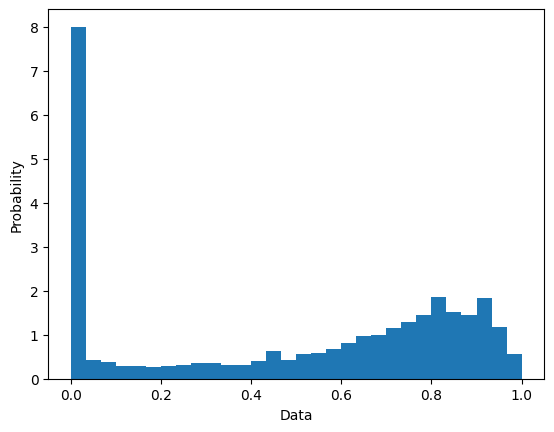

In [19]:
import matplotlib.pyplot as plt
# lista = df.results.to_list()
lista = df.old_results.to_list()
datos = [x[0] for x in lista]
plt.hist(datos, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

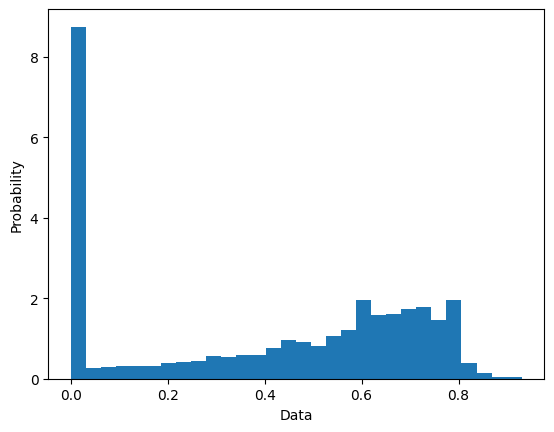

In [20]:
lista = df.old_results.to_list()
datos = [x[0] for x in lista]
plt.hist(datos, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:

df = pd.DataFrame(columns=["id", "results", "text", "language", "old_score", "old_results"])

for document in documents:
    result = scorer.score_document(ref_lang="spa", ref_script="latn", lang_segments=document["seg_langs"], document_text=document["text"], doc_id=document["id"], raw_score=False)
    df.loc[df.shape[0]] = [document["id"], result, document["text"], result[2], document["doc_scores"][0]/10, [x/10 for x in document["doc_scores"]]]


df["WDS"] = df.apply(lambda x: f"{round(x['results'][0], 2)}/{round(x['old_results'][0], 2)}", axis=1)
df["language"] = df.apply(lambda x: f"{x['results'][1]}/{x['old_results'][1]}", axis=1)
df["urls"] = df.apply(lambda x: f"{x['results'][2]}/{x['old_results'][2]}", axis=1)
df["punct"] = df.apply(lambda x: f"{x['results'][3]}/{x['old_results'][3]}", axis=1)
df["sing_chars"] = df.apply(lambda x: f"{x['results'][4]}/{x['old_results'][4]}", axis=1)
df["numbers"] = df.apply(lambda x: f"{x['results'][5]}/{x['old_results'][5]}", axis=1)
df["repet_seg"] = df.apply(lambda x: f"{x['results'][6]}/{x['old_results'][6]}", axis=1)
df["many_long"] = df.apply(lambda x: f"{x['results'][7]}/{x['old_results'][7]}", axis=1)
df["very_long"] = df.apply(lambda x: f"{x['results'][8]}/{x['old_results'][8]}", axis=1)
df["compression"] = df.apply(lambda x: f"{x['results'][9]}/{x['old_results'][9]}", axis=1)
df["short_seg"] = df.apply(lambda x: f"{x['results'][10]}/NaN", axis=1)

df_

In [ ]:



# print("nuevo:",x.score)
# print("viejo:",x.old_score)
# print(f"lang: {x.results[1]} {x.old_results[1]}\turl: {x.results[2]} {x.old_results[2]}\tpunct: {x.results[3]} {x.old_results[3]}")
# print(f"emoji: {x.results[4]} {x.old_results[4]}\tnumbe: {x.results[5]} {x.old_results[5]}\trep_seg: {x.results[6]} {x.old_results[6]}")
# print(f"long: {x.results[7]} {x.old_results[7]}\tvery_long: {x.results[8]} {x.old_results[8]}\tinfo: {x.results[9]} {x.old_results[9]}\tshort: {x.results[10]} X")
# print()
# print(x.text)

In [ ]:
df.iloc[5]

In [9]:
scorer._extract_features("banana၊\nplatano။")

{'word_chars': [7, 8],
 'punctuation_chars': [0, 0],
 'singular_chars': [0, 0],
 'numbers': [0, 0]}